In [5]:
import numpy as np 
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
import gdown
import glob

In [3]:
file_path = "test.zip"
output = file_path
if not os.path.exists("Test Set/"):
    gdown.download("https://drive.google.com/uc?id=1W94tVozlrHMY_SWE-45TvWT5PqQjElxc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

In [18]:
gender_img_height = 378
gender_img_width = 378
emotions_img_height = 224
emotions_img_width = 224
gender_class_names = ["Man", "Woman"]
emotions_class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [16]:
#Load the Model
file_path = "test.zip"
if not os.path.exists("Gender Model/"):
    gdown.download("https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
genderModel = keras.models.load_model('Gender Model/')

#Load the Model
file_path = "test.zip"
if not os.path.exists("Emotions Model/"):
    gdown.download("https://drive.google.com/uc?id=1zwwyyd0CZZBDOYt6vSliejyq7NrGbRsT", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
emotionsModel = keras.models.load_model('Emotions Model/')

Downloading...
From: https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc
To: C:\Users\Nicho\OneDrive\Desktop\UNI\MAGISTRALE\Visione Artificiale\FER-and-GR-Project\test.zip
100%|██████████| 144M/144M [00:30<00:00, 4.64MB/s] 


In [30]:
def prepare_img(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    return images

Woman 'Happy': 0.99999905, 'Neutral': 0.99843556, 'Surprise': 0.95944947


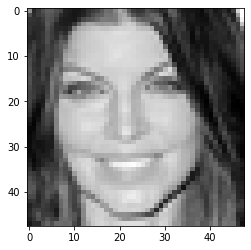

In [33]:
## Load and Predict an image
img = image.load_img("Test Set/240.png", color_mode = "grayscale")

gender_img = cv2.resize(np.float32(img), (gender_img_height, gender_img_width))
gender_classes = genderModel.predict(prepare_img(gender_img))

emotions_image = cv2.resize(np.float32(img), (emotions_img_height, emotions_img_width))
emotions_classes = emotionsModel.predict(prepare_img(emotions_image))

index = list(np.where(np.where(emotions_classes > 0.8, 1, 0)[0] == 1)[0])
dictionary = dict()
sorted_dict = dict()
for i in index:
    dictionary[emotions_class_names[i]] = emotions_classes[0][i]
sorted_keys = sorted(dictionary, key=dictionary.get, reverse=True)
for w in sorted_keys:
    sorted_dict[w] = dictionary[w]
    
print(gender_class_names[np.where(gender_classes > 0.5, 1,0)[0][1]] + " " + str(sorted_dict)[1:-1])
plt.imshow(img, cmap="gray")

In [103]:
cap = cv2.VideoCapture(0)

if (cap.isOpened() == False): 
    print("Unable to read camera feed")

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
skip_frames = 30
cur_frames = 0

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
 
while(True):
    ret, frame = cap.read()
    
    if ret == True:
        process_frame = cur_frames % skip_frames == 0
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 5)
        if process_frame:
            resized = cv2.resize(gray[y:y+h, x:x+w], (img_height,img_width))
            x = image.img_to_array(resized)
            x = np.expand_dims(x, axis=0)
            images = np.vstack([x])
            classes = model.predict(images)
            dictionary = dict()
            sorted_dict = dict()
            index = list(np.where(np.where(classes > 0.8, 1, 0)[0] == 1)[0])
            for i in index:
                dictionary[class_names[i]] = classes[0][i]
            sorted_keys = sorted(dictionary, key=dictionary.get, reverse=True)
            for w in sorted_keys:
                sorted_dict[w] = dictionary[w]
            print(str(sorted_dict)[1:-1])
            cv2.imshow('frame', frame)
            cur_frames += 1
        else:
            cv2.imshow('frame', frame)
            cur_frames += 1
        #out.write(frame)
        
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break 

cap.release()
#out.release()
 
# Closes all the frames
cv2.destroyAllWindows()

'neutral': 0.9950932, 'sad': 0.93254375, 'happy': 0.91222495
'sad': 0.9877021, 'neutral': 0.9676931, 'angry': 0.872703
'happy': 0.99999034, 'neutral': 0.9950665
'happy': 0.999928, 'neutral': 0.9504006
'neutral': 0.99826235, 'sad': 0.9956103
'sad': 0.99955946, 'neutral': 0.99725854, 'angry': 0.96075624
'sad': 0.9994784, 'neutral': 0.99687105, 'angry': 0.96109873
'happy': 0.9991685
'happy': 0.99983513
'sad': 0.9955244, 'neutral': 0.994852, 'happy': 0.8056373
'sad': 0.99634105, 'neutral': 0.9923603
'neutral': 0.9919809, 'sad': 0.97264206, 'happy': 0.9435033
'neutral': 0.9960608, 'sad': 0.9954218, 'happy': 0.8074505
'happy': 0.9987452
'happy': 0.9952598


'happy': 0.9475378
'happy': 0.9994112, 'angry': 0.91147256
'angry': 0.956739, 'fear': 0.9159893, 'happy': 0.8664384
'happy': 0.99278545, 'angry': 0.92880726
'angry': 0.9881903, 'fear': 0.9521343, 'happy': 0.8050388
'angry': 0.9861394, 'fear': 0.9642924
'neutral': 0.9930992, 'sad': 0.98017657
'happy': 0.98644024, 'neutral': 0.95864207, 'sa